In [1]:
import pandas as pd
import numpy as np
import axelrod as axl
import pathlib 

# Data

The file `outcomes.csv` contains a full set of outcomes of match results between all strategies in the library.

In [232]:
df = pd.read_csv("outcomes.csv", header=None)
df.columns = ["strategy 1", "strategy 2", "score 1", "score 2", "count"]

In [233]:
df.describe()

,score 1,score 2,count
count,2.305486e+06,2.305486e+06,2.305486e+06
mean,2.179908e+00,2.278338e+00,1.910012e+01
std,7.342048e-01,8.566840e-01,2.463772e+02
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.705000e+00,1.635000e+00,1.000000e+00
50%,2.155000e+00,2.305000e+00,2.000000e+00
75%,2.595000e+00,2.885000e+00,7.000000e+00
max,5.000000e+00,5.000000e+00,1.000000e+04


Creating a dictionary `utilities` that maps a tuple of strategy names to the mean utility for that matchup:

In [84]:
utilities = {pair: (f["score 1"].mean(), f["score 2"].mean()) 
             for pair, f in df.groupby(["strategy 1", "strategy 2"])}

For example we see that a `Cooperator` recieves a payoff of 0 against a `Defector` (which recieves a payoff of 5):

In [234]:
utilities['Cooperator', 'Defector']

(0.0, 5.0)

For random strategies we have the expected payoffs, for example here we see `Cooperator` vs `Random: 0.5`. We see that `Random:0.5` gets a mean utility of 4, which is (as expected the mean between 5 and 3.

In [242]:
utilities['Cooperator', 'Random: 0.5']

(1.5077884615384616, 3.9948076923076927)

Here is a function to get these scores out in matrix form $M$:

$$
M = \begin{pmatrix}
a & b \\
c & d
\end{pmatrix}
$$

Where:

- $a$: the utility of the first strategy encountering the first strategy;
- $b$: the utility of the first strategy encountering the second strategy;
- $c$: the utility of the second strategy encountering the first strategy;
- $d$: the utility of the second strategy encountering the second strategy;

In [243]:
def scores(strategy_pair, utilities=utilities):
    """
    Return the fitness scores:
    
        [a, b]
        [c, d]
    
    for a pair of strategies, in a population of N individuals 
    with i individuals of the first type.
    """
    try:
        s1, s2 = strategy_pair
        m = np.array([[utilities[(s1, s1)][0], utilities[(s1, s2)][0]], 
                           [utilities[(s1, s2)][1], utilities[(s2, s2)][0]]])
    except KeyError:
        s2, s1 = strategy_pair
        m = np.array([[utilities[(s2, s2)][0], utilities[(s1, s2)][1]], 
                           [utilities[(s1, s2)][0], utilities[(s1, s1)][0]]])
    return m

In [244]:
scores(("Defector", "Cooperator"))

array([[ 1.,  5.],
       [ 0.,  3.]])

Note that $M$ is order dependent:

In [245]:
scores(("Cooperator", "Defector"))

array([[ 3.,  0.],
       [ 5.,  1.]])

Using the we can compute the fitness for both strategies in a population of $N$ individuals within which there are $i$ individuals of the first type.

From [Nowak's: 'Evolutionary Dynamics'](https://www.amazon.co.uk/Evolutionary-Dynamics-Exploring-Equations-Life-x/dp/0674023382/ref=sr_1_1?ie=UTF8&qid=1479311303&sr=8-1&keywords=evolutionary+dynamics) these fitness values are given as $f_i$ (for the first strategy) and $g_i$ (for the second):

$$
f_i = \frac{a(i-1) + b(N-i)}{N-1}
$$

and 

$$
g_i = \frac{ci + d(N-i-1)}{N-1}
$$

This can be seen for $f_i$ as:

- The probability that a strategy of the first type encounters a strategy of the first type is $\frac{i - 1}{N - 1}$
- The probability that a strategy of the first type encounters a strategy of the second type is $\frac{N - i}{N - 1}$

In [253]:
def fitness(strategy_pair, N, i, utilities=utilities):
    """
    Return the fitness of a strategy pair in a population with 
    N total individuals and i individuals of the first type.
    """
    m = scores(strategy_pair, utilities)    
    
    f = (m[0, 0] * (i - 1) + m[0, 1] * (N - i)) / (N - 1)
    g = (m[1, 0] * i + m[1, 1] * (N - i - 1)) / (N - 1)
    
    return f, g

Using this we can verify that a single `Defector` with 4 `Cooperator`s would have a fitness of 5. (They would only ever meet a `Cooperator` and would thus obtain a utility of 5. Similary, $3/4$s of the time, a `Cooperator` would obtain a utility of 3, and $1/4$s of the time a utility of 0.

In [254]:
# Calculating these in the two equivalent ways:
fitness(("Defector", "Cooperator"), 5, 1), fitness(("Cooperator", "Defector"), 5, 4)

((5.0, 2.25), (2.25, 5.0))

Similary, a single `Cooperator` in a population of `Defector`s would only ever meet a `Defector` thus obtaining a utility of 0. The `Defector`s would obtain a utility of 1, $3/4$s of the time, and a utility of 5 $1/4$ of the time.

In [255]:
# Calculating these in the two equivalent ways:
fitness(("Defector", "Cooperator"), 5, 4), fitness(("Cooperator", "Defector"), 5, 1)

((2.0, 0.0), (0.0, 2.0))

Using this fitness function we can now obtain the transition probabilities:

- $p_{i,i+1}$: the probability of having 1 more individual of the first type;
- $p_{i,i-1}$: the probability of having 1 less individual of the first type;
- $p_{ii}$: the probability of no change.

From [Nowak's Evolutionary Dynamics](https://www.amazon.co.uk/Evolutionary-Dynamics-Exploring-Equations-Life-x/dp/0674023382/ref=sr_1_1?ie=UTF8&qid=1479311303&sr=8-1&keywords=evolutionary+dynamics) we have:

$$
p_{i, i+1}= \frac{if_i}{if_i+(N-i)g_i}\frac{N-i}{N}
$$

$$
p_{i, i-1}= \frac{(N-i)g_i}{if_i+(N-i)g_i}\frac{i}{N}
$$

$$
p_{ii} = 1 - p_{i, i+1} - p_{i, i-1}
$$

These probability transitions correspond the probability of a given individual being chosen for 'death' as well as  the probability of a given type of individual for 'birth' (the latter is in effect a normalisation of the fitness).

In [156]:
def transition(strategy_pair, N, i, utilities=utilities):
    """
    Return the 3 transition probabilities:
    
    P[i, i - 1]
    P[i, i]
    P[i, i + 1]
    
    Assuming: 
     - a given stratgy pair, 
     - a given total population size N
     - and a state i (the number of individuals of the first type)
    """
    fit = fitness(strategy_pair, N, i, utilities=utilities)
    
    p_up = (fit[0] * i / (fit[0] * i + fit[1] * (N - i))) * ((N - i) / N)
    
    p_down = (fit[1] * (N - i) / (fit[0] * i + fit[1] * (N - i))) * (i / N)
    
    p_stay = 1 - p_up - p_down
    return p_down, p_stay, p_up

Here we see the transition probabilities $p_{i, i-1}, p_{ii}, p_{i, i+1}$ for the case of 2 `Defector`s with 3 `Cooperator`s:

In [266]:
# Calculating these in the two equivalent ways:
transition(("Defector", "Cooperator"), 5, 2), transition(("Cooperator", "Defector"), 5, 3)[::-1]

((0.14399999999999999, 0.47199999999999998, 0.38400000000000001),
 (0.14399999999999999, 0.47199999999999998, 0.38400000000000001))

Here we see the transition probabilities $p_{i, i-1}, p_{ii}, p_{i, i+1}$ for the case of 4 `Defector`s with 1 `Cooperator`:

In [272]:
transition(("Defector", "Cooperator"), 5, 4), transition(("Cooperator", "Defector"), 5, 1)[::-1]

((0.0, 0.80000000000000004, 0.20000000000000001),
 (0.0, 0.80000000000000004, 0.20000000000000001))

Indeed in that particular case, because the score of the `Cooperator` against a population of `Defector` is 0 there is a zero probability of the number of `Cooperator`s increasing.

Let $x_i$ be the fixation probability of the first strategy in a population of $i$ individuals of the first type (and $N-i$ individuals of the second. We have:

$$
x_i = \frac{1 + \sum_{j=1}^{i-1}\prod_{k=1}^{j}\gamma_j}{1 + \sum_{j=1}^{N-1}\prod_{k=1}^{j}\gamma_j}
$$

where:

$$
\gamma_j = \frac{p_{j, j-1}}{p_{j, j+1}}
$$

In [347]:
# Using Marc's code with a modification 
# (just so that it fits with what I've 
# done so far but not precious about this)

def fixation(strategy_pair, N, i=1, utilities=utilities):
    """Return the fixation probability for each pair"""
    ratios = []
    for j in range(1, N): # ignore first and last transitions, which are likely zero
        p_down, _, p_up = transition(strategy_pair, N, i=j, utilities=utilities)
        ratios.append(p_down / p_up)
    t = np.cumprod(ratios)
    s = np.cumsum(t)
    if i > 1:
        return (1 + s[i - 2]) / (1 + s[-1])
    return 1 / (1 + s[-1])

We see that a single `Defector` has a $.6$ fixation probability in a population of `Cooperators`:

In [350]:
fixation(("Defector", "Cooperator"), 5)

0.6020696142991534

There is however, 0 chance of fixation for a single `Cooperator`:

In [351]:
fixation(("Cooperator", "Defector"), 5)

0.0

**Marc** I think something is not quite right here but I don't understand if I'm missing something or if this correct. It is due to $p_{i, i+1}$ being 0 in the case of a `Cooperator` in a population of `Defector`s.

In [354]:
fixation(("Cooperator", "Defector"), 5, 4)

nan

For strategy pairs where we have non zero scores for both players we have the expected behaviour:

In [356]:
fixation(("Alternator", "Defector"), 5), 1 - fixation(("Defector", "Alternator"), 5, 4)

(0.020044052863436124, 0.020044052863436024)

# Further things using the above framework:

In [230]:
def write_fixation(N):
    """
    Write fixation probabilities for all 
    strategy pairs to a file called 'results/fixation_N.csv'
    
    File looks like:
    
    s1, s2, x_1, x_{N - 1}
    """
    path = pathlib.Path("results")
    path.mkdir(exist_ok=True)
    path = pathlib.Path("results") / "fixation_{}.csv".format(N)

    with path.open("w") as textfile:
        for strategy_pair in utilities:
            if strategy_pair[0] != strategy_pair[1]:
                fixation_probabilities = fixation(strategy_pair, N), fixation(strategy_pair[::-1], N)
                textfile.write("{}, {}, {}, {}\n".format(*strategy_pair, *fixation_probabilities))

In [231]:
# Write all of these to file
for N in range(2, 12 + 1):
    write_fixation(N)

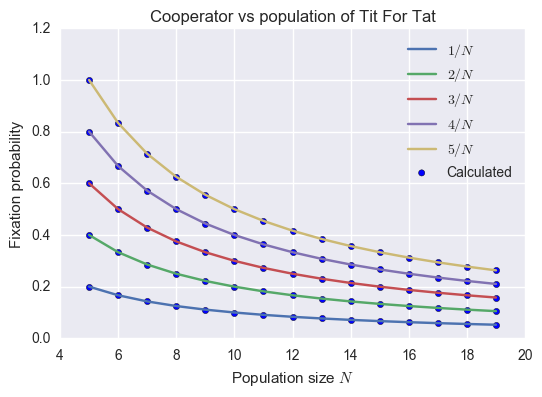

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ns = range(5, 20)
plt.figure()
for i in range(1, min(ns) + 1):
    theoretic = [i / n for n in ns]
    calculated = [fixation(("Cooperator", "Tit For Tat"), n, i) for n in ns]
    plt.plot(ns, theoretic, label="${}/N$".format(i))
    plt.title("Cooperator vs population of Tit For Tat")
    if i == min(ns):
        plt.scatter(ns, calculated, label="Calculated")
    else:
        plt.scatter(ns, calculated)

    plt.xlabel("Population size $N$")
    plt.ylabel("Fixation probability")
    plt.legend();

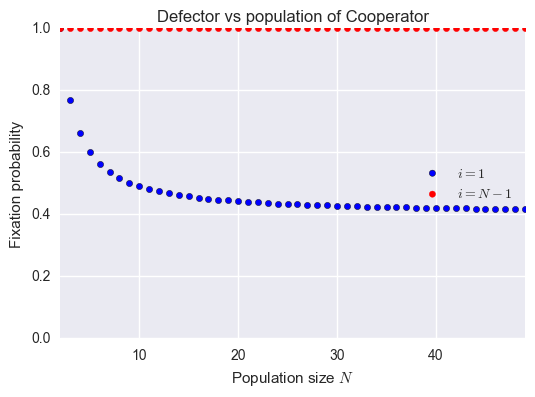

In [226]:
plt.figure()

strategies = ("Defector", "Cooperator")
ns = range(2, 50)
invader = [fixation(strategies, n) for n in ns]   
resistor = [fixation(strategies, n, n - 1) for n in ns] 
plt.title("{} vs population of {}".format(*strategies))
plt.scatter(ns, invader, label="$i=1$")
plt.scatter(ns, resistor, color="red", label="$i=N-1$")

plt.xlabel("Population size $N$")
plt.ylabel("Fixation probability")
plt.ylim(0, 1)
plt.xlim(min(ns), max(ns))
plt.legend(loc=5);

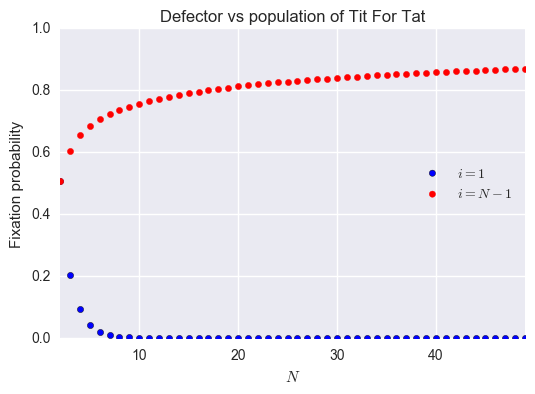

In [225]:
plt.figure()


strategies = ("Defector", "Tit For Tat")
ns = range(2, 50)
invader = [fixation(strategies, n) for n in ns]   
resistor = [fixation(strategies, n, n - 1) for n in ns] 
plt.title("{} vs population of {}".format(*strategies))
plt.scatter(ns, invader, label="$i=1$")
plt.scatter(ns, resistor, color="red", label="$i=N-1$")

plt.xlabel("$N$")
plt.ylabel("Fixation probability")
plt.ylim(0, 1)
plt.xlim(min(ns), max(ns))
plt.legend(loc=5);

In [44]:
players = [axl.Defector, axl.Cooperator]
N, repetitions, turns, fixation_count = 10, 200, 50, 0
for seed in range(repetitions):
    initial_population = [players[0]()] + [players[1]()] * (N - 1)
    mp = axl.MoranProcess(initial_population, turns=turns)
    mp.play()
    if mp.winning_strategy_name == "Defector":
        fixation_count += 1
fixation_count / repetitions

0.135